In [1]:
#https://keras.io/examples/rl/deep_q_network_breakout/#train
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.models import Model, load_model
from keras.models import Sequential
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten, ZeroPadding2D, UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.losses import Huber
from keras.regularizers import l2
from keras import initializers
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

Using TensorFlow backend.


In [2]:
import os.path
import pandas as pd 
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [26]:
dim = (50,50) 
pathname = r"C:\Users\User\Documents\DeepLearning\Reinforcement"
datadirname = "data"
testdirname = "test"
validdirname = "valid"
modeldirname = "model"
datacsvname = "data.csv"
modeljsonname="model-regr.json"
modelweightname="model-regr.h5"


MAXREWARD = 1.0
PENALTY = -1.0
MOVEPENALTY = 0.0

MAXREWARD_OVER =1.0
PENALTY_OVER = -1.0
MOVEPENALTY_OVER = 0.0

MAXREWARD_OVER = 1.0
PENALTY_OVER = -1.0
MOVEPENALTY_OVER = 0.0

DISCOUNT = 0.99


actionstonum = {"RIGHT": 0,
           "LEFT": 1,
           "UP" : 2,
           "DOWN" : 3,
          }
numtoactions = {0: "RIGHT",
           1: "LEFT",
           2: "UP",
           3: "DOWN",
          }

In [4]:
def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(dim[0], dim[1], 3,))

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(4, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)

# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model()

In [22]:
opt = keras.optimizers.Adam(learning_rate=3.0e-4, clipnorm=1.0)
# or mean_squared_logarithmic_error ?
# or mean_squared_error
model.compile(loss=Huber(),optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 11, 11, 32)        6176      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 64)          32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052  

In [6]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(os.path.join(pathname, modeldirname,modelweightname), verbose=1, save_best_only=True, save_weights_only=True)
]

In [42]:
def load_replay_memory(pathname = pathname, datadirname = datadirname, datacsvname = datacsvname):

    shufflelist = []
    
    assert os.path.isfile(os.path.join(pathname, datadirname,datacsvname)) == True

    f = open(os.path.join(os.path.join(pathname, datadirname,datacsvname)), "r")

    df = pd.read_csv(f, index_col = 0) 

    for index, row in df.iterrows():

        currentpicname = row["currentstate"]
        action = actionstonum[row["action"]]
        reward = row["reward"]
        nextpicname = row["nextstate"]
        terminated = row["terminated"]
        
        sxpos = row["sxpos"]
        sypos = row["sypos"]
        fxpos = row["fxpos"]
        fypos = row["fypos"]


        assert os.path.isfile(os.path.join(pathname, datadirname,currentpicname)) == True
        assert (action < 5 and action >= 0)
        assert isinstance(reward,int) or isinstance(reward, float)
        assert os.path.isfile(os.path.join(pathname, datadirname,nextpicname)) == True

        
        if reward != PENALTY:
            assert sxpos <= 200 and sxpos >= 0
            assert sypos <= 200 and sypos >= 0
            assert fxpos <= 200 and fxpos >= 0
            assert fypos <= 200 and fypos >= 0
            shufflelist.append([currentpicname,action,reward,nextpicname, terminated, sxpos, sypos, fxpos, fypos])

    random.shuffle(shufflelist)

    f.close()

    return shufflelist

In [11]:
def generatebatchdata(batchsize):
    shufflelist = []
    shufflelist = load_replay_memory()
    print(f"length of shufflelist is {len(shufflelist)}")

    while True:
        batchstart = 0
        batchend = batchsize    
        
        while batchstart < len(shufflelist):
            
            imagelist = []
            targetlist = []
            
            limit = min(batchend, len(shufflelist))

            for i in range(batchstart, limit):

                filename = os.path.join(pathname, datadirname, shufflelist[i][3])
                imagelist.append(cv2.imread(filename,cv2.IMREAD_COLOR))
                targetlist.append([shufflelist[i][5], shufflelist[i][6], shufflelist[i][7], shufflelist[i][8]])
                
            
            traindata = np.array(imagelist, dtype=np.float32) / 255.0
            targetlist = np.array(targetlist, dtype=np.float32)
    
            yield (traindata,targetlist)    

            batchstart += batchsize   
            batchend += batchsize

In [12]:
generator_train = generatebatchdata(20)
#generator_valid = generatebatchdata(2, os.path.join(pathname, validdirname), datacsvname)

In [24]:
#model.fit_generator(generator_train,steps_per_epoch=700, epochs=10, callbacks=callbacks, validation_data=generator_valid, validation_steps=150)
model.fit_generator(generator_train,steps_per_epoch=1400, epochs=4)

Epoch 1/4
1400/1400 [==============================] - 19s 14ms/step - loss: 6.1357 - accuracy: 0.8626
Epoch 2/4
1400/1400 [==============================] - 19s 14ms/step - loss: 6.0814 - accuracy: 0.8627
Epoch 3/4
1400/1400 [==============================] - 19s 14ms/step - loss: 6.0431 - accuracy: 0.8631
Epoch 4/4
1400/1400 [==============================] - 19s 14ms/step - loss: 5.9488 - accuracy: 0.8634


In [25]:
model_json = model.to_json()
with open(os.path.join(pathname, modeldirname,modeljsonname), "w") as json_file:
    json_file.write(model_json)

model.save_weights(os.path.join(pathname, modeldirname,modelweightname))

In [13]:
model.load_weights(os.path.join(pathname, modeldirname,modelweightname))
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 130, 130, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 66, 66, 64)        0   

In [118]:
imagetestlist = []

imagetestnames = os.listdir(os.path.join(pathname, testdirname))
imagetestnames.sort()

for imagename in imagetestnames:
    if imagename.endswith(".png"):
        imagetestlist.append(cv2.imread(os.path.join(pathname, testdirname, imagename),cv2.IMREAD_COLOR ))
        
imagetestlist = np.array(imagetestlist, dtype=np.float32)/255.0

print(imagetestlist[0].shape)

(50, 50, 3)


In [46]:
#testlist = []
#testlist =  load_replay_memory(pathname, testdirname, datacsvname)
#len(testlist)

261

In [ ]:
#imagetestlist = []
#imagetestdata = []
#for item, (cs, a, rw, fs, term, px, py, fx, fy) in enumerate(testlist):
    
    

In [119]:
predictionslist = model.predict(imagetestlist, batch_size=1, verbose=1)

532/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [120]:
imagetestlist = np.array(imagetestlist, dtype=np.int)
imagetestlist = imagetestlist*255

[23. 41. 33. 27.]


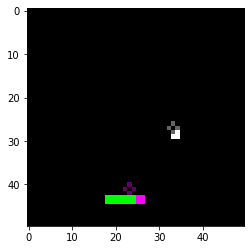

In [127]:
#'def showpic(i):
ind = 99


print(predictionslist[ind]//4)



new = cv2.circle(imagetestlist[ind], (int(predictionslist[ind][0]//4), int(predictionslist[ind][1]//4)), 1, (100,0,100), 1)
new = cv2.circle(new, (int(predictionslist[ind][2]//4), int(predictionslist[ind][3]//4)), 1, (100,100,100), 1)

plt.imshow(new)

In [69]:
s = "current_1_2.png"
print(str.split(s))

['current_1_2.png']


In [68]:
[int(s) for s in str.split(s) if s.isdigit()]

[]

In [74]:
import re
s = re.findall(r'\d+', 'current_145_2.png')[0]
print(s)

current_145
